# Отток клиентов

**Цель исследования**

Построить модель для задачи классификации, которая будет предсказывать уход клиента, с F1-мерой не менее 0.59.

## Подготовка данных

### Загрузка данных

In [56]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.utils import shuffle

In [2]:
# чтение файлов с данными и сохранение
df = pd.read_csv('/datasets/Churn.csv')

In [3]:
# получение первых строк
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [4]:
# получение общей информации
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


В таблице 10000 строк, 14 колонок.

Признаки
- `RowNumber` — индекс строки в данных
- `CustomerId` — уникальный идентификатор клиента
- `Surname` — фамилия
- `CreditScore` — кредитный рейтинг
- `Geography` — страна проживания
- `Gender` — пол
- `Age` — возраст
- `Tenure` — сколько лет человек является клиентом банка
- `Balance` — баланс на счёте
- `NumOfProducts` — количество продуктов банка, используемых клиентом
- `HasCrCard` — наличие кредитной карты
- `IsActiveMember` — активность клиента
- `EstimatedSalary` — предполагаемая зарплата

Целевой признак:
- `Exited` — факт ухода клиента

При беглом осмотре данных можно выделить следующие пункты для обработки:
- Регист названия столбцов
- Наличие пропусков в столбце `Tenure`
- Столбец `RowNumber` — индекс строки в данных — дублирует индексы в таблице 

### Предобработка и проверка данных

Приведем название стобцов к удобному виду (snake_case). 

In [5]:
# функция для преобразоания верблюжего регистра в змеиный
def snake_case(columns):
    list1 = []
    for column in columns:
        # разделение названия колонки на слова по заглавным буквам
        split_name = re.sub(r'([A-Z])', r' \1', column).split()
        # соединяе слова из названия через _ и делаем все буквы строчными
        list1.append('_'.join(split_name).lower())
    return list1

In [6]:
# переименование столбцов
df.set_axis(snake_case(list(df.columns)), axis=1, inplace = True)
# проверка
df.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

Удалим столбец `row_number`, поскольку в таблице уже присутствует индексация строк

In [7]:
df = df.drop(['row_number'], axis=1)

Проверим данные на наличие дубликатов и выбивающихся значений.

In [8]:
df.duplicated().sum()

0

Проверим столбцы с категориальными данными. Столбец `customer_id` должен содержать столько же уникальных значений, сколько строк в таблице. Столбцы `geography`, `gender` проверим на наличие неявных дубникатов (например, записанных в разных регистрах), просмотрев их уникальные значения.

In [9]:
# число уникльных значений столбца равно длине таблицы
len(df['customer_id'].unique()) == len(df)

True

In [10]:
# просмотр уникальных значений
df['geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [11]:
# просмотр уникальных значений
df['gender'].unique()

array(['Female', 'Male'], dtype=object)

В этих столбцах все впорядке. Перейдем к рассмотрению остальных.


                   credit_score                   
count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: credit_score, dtype: float64


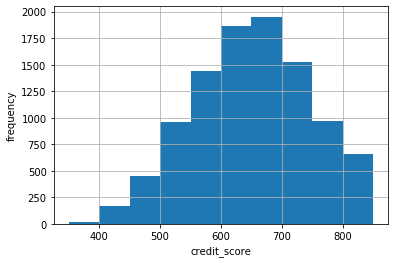


                       age                        
count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: age, dtype: float64


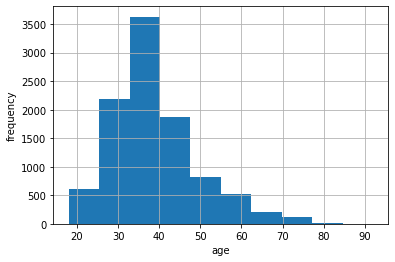


                      tenure                      
count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: tenure, dtype: float64


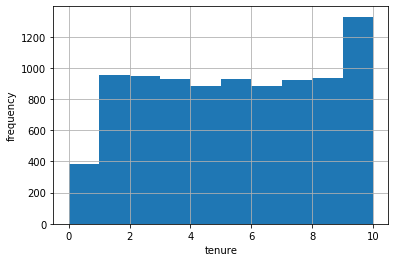


                     balance                      
count     10000.000000
mean      76485.889288
std       62397.405202
min           0.000000
25%           0.000000
50%       97198.540000
75%      127644.240000
max      250898.090000
Name: balance, dtype: float64


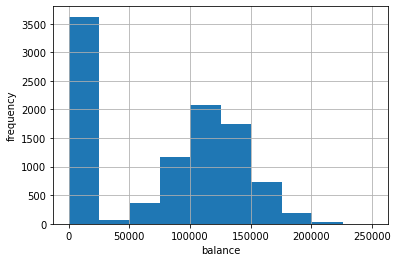


                 estimated_salary                 
count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
25%       51002.110000
50%      100193.915000
75%      149388.247500
max      199992.480000
Name: estimated_salary, dtype: float64


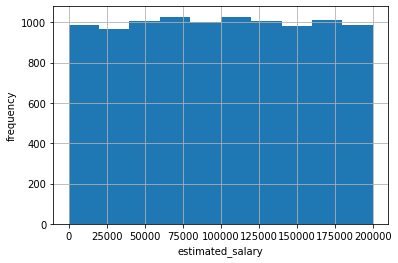


                 num_of_products                  
count    10000.000000
mean         1.530200
std          0.581654
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          4.000000
Name: num_of_products, dtype: float64


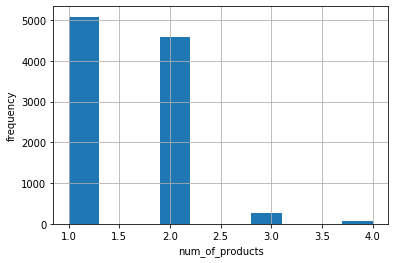

In [12]:
list_num = ['credit_score', 'age', 'tenure','balance', 'estimated_salary', 'num_of_products']
for i in list_num:
    print(f'\n{i:^50}')
    print(df[i].describe())
    df[i].hist()
    plt.xlabel(i)
    plt.ylabel('frequency')
    plt.show()

In [13]:
list_bool = ['has_cr_card', 'is_active_member', 'exited']
for i in list_bool:
    print(df.pivot_table(index=i, values='customer_id', aggfunc='count'), '\n')

             customer_id
has_cr_card             
0                   2945
1                   7055 

                  customer_id
is_active_member             
0                        4849
1                        5151 

        customer_id
exited             
0              7963
1              2037 



Можно сказать, что с данными все в порядке

Рассмотрим столбец `tenure`, в котором обнаружены пропуски.

In [14]:
df['tenure'].isna().sum() / len(df) * 100

9.09

В этом столбце 9% пропусков. Посмотрим на некоторые из них

In [15]:
df.query('tenure.isna()').tail(7)

,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
9931,15647800,Greco,850,France,Female,34,NaN,101266.51,1,1,0,33501.98,0
9938,15593496,Korovin,526,Spain,Female,36,NaN,91132.18,1,0,0,58111.71,0
9944,15703923,Cameron,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,15707861,Nucci,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,15642785,Douglas,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,15586914,Nepean,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0
9999,15628319,Walker,792,France,Female,28,NaN,130142.79,1,1,0,38190.78,0


Очевидных зависимостей пропусков со значеними других столбцов нет. Распределение достаточно равномерное, за исключением клиентов, пользующихся услугами 10 лет (их большинство), и клиентов, пользующихся услугами банка менее года (меньшество).

Восстановить пропущенные значения по информации из других колонок не представляется возможным. Также нельзя наверняка утверждать, что пропуски означают пользование услугами банка менее года (то есть 0). Заполнение пропусков медианой или средним в данном случае может исказить реальную картину.
Заполним пропуски "-1".

In [16]:
df['tenure'] = df['tenure'].fillna(-1)
df['tenure'].isna().sum()

0

### Подготовка признаков

Необходимо преобразовать категориальные признаки в числа. Будем использовать технику прямого кодирования, поскольку категориальных данных немного. Убрем по одному столбцу из новых столбцов с дамми-признаками, поскольку он излишен. Не будем учитывать столбец с фамилиями пользователей, поскольку он не является реальным признаком и может негативно сказаться при получении дамми-признаков, поскольку в нем есть повторяющиеся значения. Столбец с id  тоже не будем принимать во внимание

In [17]:
# получение дамми-признаков
df = pd.get_dummies(df.drop(['surname', 'customer_id'], axis=1), drop_first=True)
# проверка
df.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


Выделим из данных целевой признак (столбец `target`) и остальные 

In [18]:
# целевой признак
target = df['exited']
# признаки
features = df.drop('exited', axis=1)

Разделим данные на три группы: обучающий набор, валидационные и тестовый. Сначала выделим обучающую выборку (60%), а остальные данные на равные части.

In [19]:
# выделение обучающей выборки
features_train, features_other, target_train, target_other = train_test_split(
    features, target, test_size=0.4, random_state=12345)
# разбиение оставшихся данных на валидационную и тестувую
features_valid, features_test, target_valid, target_test = train_test_split(
    features_other, target_other, test_size=0.5, random_state=12345)
# проверка размера
print('Размер обучающей выборки:', features_train.shape)
print('Размер валидационной выборки:', features_valid.shape)
print('Размер тестовой выборки:', features_test.shape)

Размер обучающей выборки: (6000, 11)
Размер валидационной выборки: (2000, 11)
Размер тестовой выборки: (2000, 11)


Отмасштабируем числовые признаки с помощью z-преобразования. Таким образом все количественные признаки для алгоритма станут более равноценными.

In [20]:
pd.options.mode.chained_assignment = None
scaler = StandardScaler()
scaler.fit(features_train[list_num])

features_train[list_num] = scaler.transform(features_train[list_num])
features_valid[list_num]  = scaler.transform(features_valid[list_num])
features_test[list_num]  = scaler.transform(features_test[list_num])

In [21]:
features_train.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
7479,-0.886751,-0.373192,1.083651,1.232271,-0.891560,1,0,-0.187705,0,1,1
3411,0.608663,-0.183385,1.083651,0.600563,-0.891560,0,0,-0.333945,0,0,0
6027,2.052152,0.480939,-0.452862,1.027098,0.830152,0,1,1.503095,1,0,1
1247,-1.457915,-1.417129,0.469046,-1.233163,0.830152,1,0,-1.071061,0,0,1
3716,0.130961,-1.132419,-0.760164,1.140475,-0.891560,0,0,1.524268,1,0,0


In [22]:
features_valid.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
8532,-0.699824,-0.373192,-0.760164,-1.233163,0.830152,1,0,-0.015173,0,0,0
5799,-0.284431,0.575842,-0.452862,-1.233163,-0.891560,1,1,1.471724,0,0,0
5511,0.151731,-0.657902,-1.374769,0.438711,-0.891560,1,0,-1.367107,1,0,1
7365,-0.876366,-0.278288,1.698257,1.239884,-0.891560,1,1,-0.786517,0,1,0
7367,-0.481743,0.291132,1.698257,-1.233163,0.830152,1,0,1.358533,0,1,1


In [73]:
features_test.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
7041,-2.226392,-0.088482,-0.760164,-1.233163,0.830152,1,0,0.647083,0,0,1
5709,-0.087120,0.006422,1.390954,-1.233163,-0.891560,1,0,-1.658410,0,0,0
7117,-0.917905,-0.752805,0.161744,0.722307,-0.891560,1,1,-1.369334,0,1,1
7775,-0.253277,0.101325,1.698257,-1.233163,0.830152,1,0,0.075086,0,1,1
8735,0.785204,-0.847708,1.698257,0.615625,-0.891560,0,1,-1.070919,0,0,1


## Исследование задачи

Посмотрим на балланс классов

0    0.7963
1    0.2037
Name: exited, dtype: float64


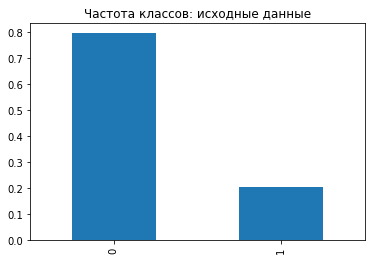

In [23]:
orig_frequency = df['exited'].value_counts(normalize=True)
print(orig_frequency)
orig_frequency.plot(kind='bar')
plt.title('Частота классов: исходные данные')
plt.show()

Наблюдается дисбаланс: классы находятся в соотношении примерно 1:4, причем отрицательный класс больше. 

Попробуем обучить модели логистической регрессии, дерева решений и случайного леса на таких данных и сравнить их с константной моделью.

In [24]:
# список для записи параметров
list_accuracy = []

0    0.7965
1    0.2035
dtype: float64


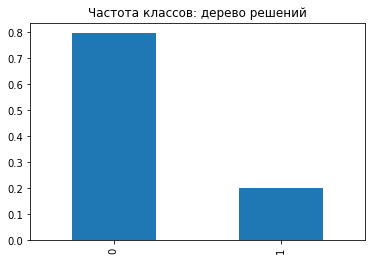

accuracy: 0.7875
f1: 0.48484848484848486
auc_roc: 0.6738109352222068


In [25]:
# создение модели решиющего дерева
model = DecisionTreeClassifier(random_state=12345)
# обучение
model.fit(features_train, target_train)
# получение предсказаний на валидационной выборке
predicted_valid = model.predict(features_valid)
# подсчет частоты классов
class_frequency = pd.Series(predicted_valid).value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')
plt.title('Частота классов: дерево решений')
plt.show()
# метрики
accuracy = accuracy_score(target_valid, predicted_valid)
print('accuracy:', accuracy)
f1 = f1_score(target_valid, predicted_valid)
print('f1:', f1)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('auc_roc:', auc_roc)
list_accuracy.append(['tree', accuracy, f1, auc_roc])

0    0.9125
1    0.0875
dtype: float64


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


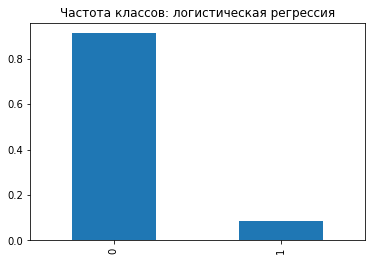

accuracy: 0.8025
f1: 0.33389544688026984
auc_roc: 0.7585576975423272


In [26]:
# создение модели логистической модели
model = LogisticRegression(random_state=12345)
# обучение 
model.fit(features_train, target_train)
# предсказания на валидационной выборке
predicted_valid = model.predict(features_valid)
# подсчет частоты классов
class_frequency = pd.Series(predicted_valid).value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')
plt.title('Частота классов: логистическая регрессия')
plt.show()
# метрики
accuracy = accuracy_score(target_valid, predicted_valid)
print('accuracy:', accuracy)
f1 = f1_score(target_valid, predicted_valid)
print('f1:', f1)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('auc_roc:', auc_roc)
list_accuracy.append(['logreg', accuracy, f1, auc_roc])

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0    0.875
1    0.125
dtype: float64


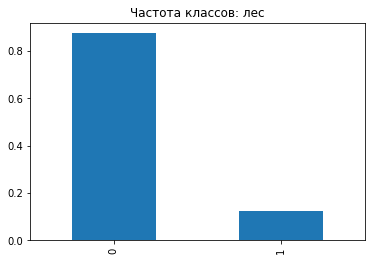

accuracy: 0.85
f1: 0.5508982035928144
auc_roc: 0.8097738311990756


In [27]:
# создение модели случайного леса
model = RandomForestClassifier(random_state=12345)
# обучение
model.fit(features_train, target_train)
# получение предсказаний на валидационной выборке
predicted_valid = model.predict(features_valid)
# подсчет частоты классов
class_frequency = pd.Series(predicted_valid).value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')
plt.title('Частота классов: лес')
plt.show()
# метрики
accuracy = accuracy_score(target_valid, predicted_valid)
print('accuracy:', accuracy)
f1 = f1_score(target_valid, predicted_valid)
print('f1:', f1)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('auc_roc:', auc_roc)
list_accuracy.append(['forest', accuracy, f1, auc_roc])


Сравним данные полученные c константной моделью, которая будет прогнозировать только отрицательный класс.

In [28]:
target_pred_const = pd.Series([0]*len(target))
accuracy = accuracy_score(target, target_pred_const)
print('accuracy:', accuracy)
list_accuracy.append(['const', accuracy, '-', '-'])

accuracy: 0.7963


Сравним полученные результаты.

In [29]:
imbalance = pd.DataFrame(list_accuracy, columns =['model', 'accuracy', 'f1', 'auc_roc']).round(3)
imbalance

,model,accuracy,f1,auc_roc
0,tree,0.788,0.484848,0.673811
1,logreg,0.802,0.333895,0.758558
2,forest,0.850,0.550898,0.809774
3,const,0.796,-,-


**Вывод**

- Константная модель выдает значение accuracy даже лучше, чем дерево решений, и в целом ее accuracy сопоставима с моделями. Эта метрика не может быть использована  при дисбаллансе классов: можно предсказывать, что ни один клиент не уйдет из банка, и доля правильных ответов будет сопоставима с долей правильных ответов модели. Значит, модель не пройдет проверку на адекватность.
- Значение F1-меры составляет от 0,33 у логистической регрессии до 0,55 у случайного леса. (F1-мера должна приближаться к 1)
- AOC-ROC составляет от 0,67 у логистической регресии до 0,81 у случайного леса. (AOC-ROC случайной модели = 0,5)
- Случайный лес показывает лучшие значения метрик F1-меры и AOC-ROC.

Попробуем устранить дисбаланс классов, чтобы повысить значения F1-меры.

## Борьба с дисбалансом

### Методы борьбы с дисбалансом

Посмотрим на самой быстрой модели (логистическая регрессия), как изменится F1-мера при использовании разных методов борьбы с дисбаллансом. Для некоторых методов найдем наиболее эффективные параметры.

In [30]:
methods = []

Взвешивание классов

In [31]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
f1 = f1_score(target_valid, predicted_valid)
print(f"F1: {f1:.3}")

F1: 0.489


In [32]:
methods.append(['class_weight', f1, '-'])

Увеличение выборки

In [33]:
# функция для увеличения выборки
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

uplist = pd.DataFrame([], columns=['repeat','F1'])

best_parameter = 0
best_f1 = 0
for i in range(1, 11, 1):
    features_upsampled, target_upsampled = upsample(features_train, target_train, i)

    model = LogisticRegression(random_state = 12345, solver='liblinear')
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    uplist.loc[len(uplist.index)] = [i, f1]
    if f1 > best_f1:
        best_parameter = i
        best_f1 = f1

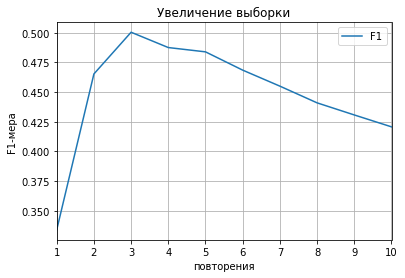

In [34]:
uplist.plot(x='repeat', y='F1', grid=True)
plt.title('Увеличение выборки')
plt.ylabel('F1-мера')
plt.xlabel('повторения')
plt.show()

Наилучший результат достигается при повторении 3 раза

In [35]:
methods.append(['upsample', best_f1, best_parameter])

Уменьшение выбоки

In [36]:
# функция для уменьшения выборки
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

downlist = pd.DataFrame([], columns=['fraction','F1'])

best_parameter = 0
best_f1 = 0
for i in np.arange(0.1, 1.0, 0.1):
    features_downsampled, target_downsampled = downsample(features_train, target_train, i)
    model = LogisticRegression(random_state=12345, solver='liblinear')
    model.fit(features_downsampled, target_downsampled)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    downlist.loc[len(downlist.index)] = [i, f1]
    if f1 > best_f1:
        best_parameter = i
        best_f1 = f1

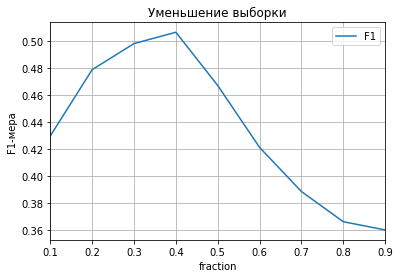

In [37]:
downlist.plot(x='fraction', y='F1', grid=True)
plt.title('Уменьшение выборки')
plt.ylabel('F1-мера')
plt.xlabel('fraction')
plt.show()

Наилучший результат достигается при доли 0.4.

In [38]:
methods.append(['downsample', best_f1, best_parameter])

Изменение порога

In [39]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

threshold_list = pd.DataFrame([], columns=['threshold','F1'])

best_parameter = 0
best_f1 = 0
for i in np.arange(0, 0.5, 0.02):
    predicted_valid = probabilities_one_valid > i 
    f1 = f1_score(target_valid, predicted_valid)
    threshold_list.loc[len(threshold_list.index)] = [i, f1]
    if f1 > best_f1:
        best_parameter = i
        best_f1 = f1

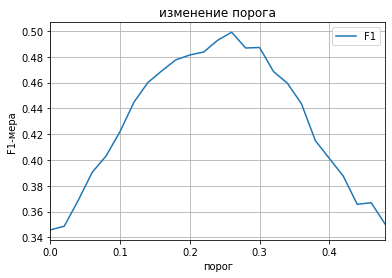

In [40]:
threshold_list.plot(x='threshold', y='F1', grid=True)
plt.title('изменение порога')
plt.ylabel('F1-мера')
plt.xlabel('порог')
plt.show()

Наилучший результат при пороге равном 0,26.

In [41]:
methods.append(['threshold', best_f1, best_parameter])

Сравним методы

In [42]:
methods = pd.DataFrame(methods, columns =['methods', 'f1', 'parameter'])
methods['f1'] = methods['f1'].round(3)
methods

,methods,f1,parameter
0,class_weight,0.489,-
1,upsample,0.500,3
2,downsample,0.507,0.4
3,threshold,0.499,0.26


В целом все методы дают сравнительно одинаковый результат.

### Поиск наилучшей модели

При исследовании на дисбаланс наилучший результат выдавала модель случайного леса. На всякий случай проверим, изменится ли ситуация, когда дисбалланс будет учтен. Проверим на методе уменьшения выборки модели.

In [43]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.4)

In [44]:
best_models = []

In [45]:
# LogisticRegression
model1 = LogisticRegression(random_state=12345, solver='liblinear')
model1.fit(features_downsampled, target_downsampled)
predicted_valid = model1.predict(features_valid)

f1 = f1_score(target_valid, predicted_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

In [46]:
best_models.append(['lodreg_model', f1, auc_roc])

In [47]:
# DecisionTreeClassifier
best_model_tree = None
best_f1_tree = 0
auc_roc_tree = 0

for depth in range(1, 21):
    model2 = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model2.fit(features_downsampled, target_downsampled)
    predicted_valid = model2.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    
    # определение лучшей модели
    if f1 > best_f1_tree:
        best_model_tree = model2
        best_f1_tree = f1

In [48]:
probabilities_valid = best_model_tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

best_models.append(['best_model_tree', best_f1_tree, auc_roc])

In [49]:
%%time
# RandomForestClassifier
best_model_forest = None
best_f1_forest = 0
for depth in range(1, 20, 1):
    for n in range(10, 45, 1):
        model3 = RandomForestClassifier(random_state=12345, n_estimators=n, max_depth=depth) 
        model3.fit(features_downsampled, target_downsampled)
        predicted_valid = model3.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid)
        # определение лучшей модели
        if f1 > best_f1_forest:
            best_model_forest = model3
            best_f1_forest = f1

CPU times: user 1min 43s, sys: 300 ms, total: 1min 43s
Wall time: 1min 46s


In [50]:
probabilities_valid = best_model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

best_models.append(['best_model_forest', best_f1_forest, auc_roc])

Сравним метрики

In [51]:
best_models = pd.DataFrame(best_models, columns =['model', 'f1', 'auc_roc'])
best_models = best_models.round(3)
best_models

,model,f1,auc_roc
0,lodreg_model,0.507,0.759
1,best_model_tree,0.565,0.810
2,best_model_forest,0.637,0.844


Как и в случае без учета диссбаланса, наилучший результат у случайного леса.

Проверим на модели случайного леса, удастся ли с помощью других методов борьбы с дисбаллансом повысить значение метрик.

In [52]:
best_model_methods = [['downsample', best_f1_forest, auc_roc]]

In [53]:
%%time
# class_weight
best_model_forest1 = None
best_f1_forest1 = 0
for depth in range(1, 20, 1):
    for n in range(10, 45, 1):
        model4 = RandomForestClassifier(random_state=12345, n_estimators=n, max_depth=depth, class_weight='balanced') 
        model4.fit(features_train, target_train)
        predicted_valid = model4.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid)
        # определение лучшей модели
        if f1 > best_f1_forest1:
            best_model_forest1 = model4
            best_f1_forest1 = f1

CPU times: user 2min 17s, sys: 578 ms, total: 2min 17s
Wall time: 2min 19s


In [54]:
probabilities_valid = best_model_forest1.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc1 = roc_auc_score(target_valid, probabilities_one_valid)

In [57]:
best_model_methods.append(['class_weight', best_f1_forest1, auc_roc1])

In [58]:
%%time
# upsample
features_upsampled, target_upsampled = upsample(features_train, target_train, 3)
best_model_forest2 = None
best_f1_forest2 = 0
for depth in range(1, 20, 1):
    for n in range(10, 45, 1):
        model5 = RandomForestClassifier(random_state=12345, n_estimators=n, max_depth=depth) 
        model5.fit(features_upsampled, target_upsampled)
        predicted_valid = model5.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid)
        # определение лучшей модели
        if f1 > best_f1_forest2:
            best_model_forest2 = model5
            best_f1_forest2 = f1

CPU times: user 3min 1s, sys: 606 ms, total: 3min 2s
Wall time: 3min 4s


In [59]:
probabilities_valid = best_model_forest2.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc2 = roc_auc_score(target_valid, probabilities_one_valid)

In [60]:
best_model_methods.append(['upsample', best_f1_forest2, auc_roc2])

In [61]:
%%time
# threshold 
best_model_forest3 = None
best_f1_forest3 = 0
for depth in range(1, 20, 1):
    for n in range(10, 45, 1):
        model5 = RandomForestClassifier(random_state=12345, n_estimators=n, max_depth=depth) 
        model5.fit(features_train, target_train)
        probabilities_valid = model5.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]

        predicted_valid = probabilities_one_valid > 0.26 
        f1 = f1_score(target_valid, predicted_valid)
        # определение лучшей модели
        if f1 > best_f1_forest3:
            best_model_forest3 = model5
            best_f1_forest3 = f1

CPU times: user 2min 18s, sys: 299 ms, total: 2min 19s
Wall time: 2min 19s


In [62]:
probabilities_valid = best_model_forest3.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc3 = roc_auc_score(target_valid, probabilities_one_valid)

In [63]:
best_model_methods.append(['threshold', best_f1_forest3, auc_roc3])

Сравним показатели.

In [64]:
best_model_methods = pd.DataFrame(best_model_methods, columns=['method', 'f1', 'auc_roc']).round(3)
best_model_methods

,method,f1,auc_roc
0,downsample,0.637,0.844
1,class_weight,0.632,0.854
2,upsample,0.643,0.852
3,threshold,0.634,0.852


**Вывод**

Наилучшие значения показывает метод взвешивания классов (AUC_ROC наибольшая) и модель случайного леса со следующими гиперпараметрами:

In [65]:
best_model_forest1

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=42, n_jobs=None, oob_score=False,
                       random_state=12345, verbose=0, warm_start=False)

## Тестирование модели

F1-мера 0.609
AUC-ROC 0.853


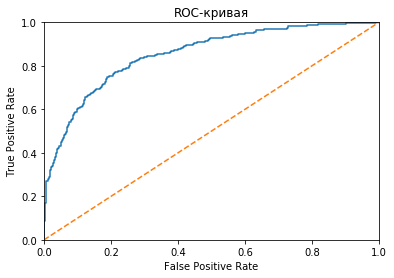

In [70]:
predicted_test = best_model_forest1.predict(features_test)
print(f'F1-мера {f1_score(target_test, predicted_test):.3}')
probabilities_test = best_model_forest1.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
print(f'AUC-ROC {roc_auc_score(target_test, probabilities_one_test):.3}')

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Значение AUC-ROC практически такое же как на валидационной выборке. Значение F1-меры уменьшилось.

## Вывод

Была построена модель для задачи классификации, которая предсказывает уход клиента из банка. Модель представляет собой случайный лес с гипер параметрами: n_estimators=42, max_depth=7, class_weight='balanced' (учет дисбалланса классов). 

In [ ]:
# лучшая модель
best_model_forest1

Для этого были осуществлены следующие этапы:
1. Задружены данные.
2. Выполнена предобработка данных:
    - Регист названия столбцов изменен на змеиный
    - Заполенены пропуски в столбце `Tenure`
    - Удален столбец. `row_number` (дублирующий индексы строк).
3.Подготовлены признаки:
    - категориальные данные преобразованы в числовые методом прямого кодирования с учетом возможной дамми-ловушки.
    - выделен целевой признак и признаки (без учета столбцов `surname`, `customer_id`).
    - данные разбиты на три группы: обучающую (60%), валидационную (20%) и тестовую (20%) выборки.
    - количественные данные отмасштабированы с помощью z-преобразования.
4. Исследованы баланс классов. 
    - классы находятся в соотношении примерно 1:4, причем отрицательный класс больше.
    - обучены три модели (логической регресси, решающего дерева и случайного леса) без учета балланса. Значение F1-меры составляет от 0,33 у логистической регрессии до 0,55 у случайного леса. (F1-мера должна приближаться к 1). AOC-ROC составляет от 0,67 у логистической регресии до 0,81 у случайного леса. (AOC-ROC случайной модели = 0,5). Случайный лес показывает лучшие значения метрик F1-меры и AOC-ROC.

In [ ]:
imbalance

5. Рассмотрены различне методы борьбы с дисбалансом на примере самой "скоростной" модели логистической регресси и найдены наиболее удачные параметры для некоторых.

In [ ]:
methods

6. Сравнивались F1-мера разных моделей при учете дисбалланса. Как и в случае без учета дисбаланса лучший результат показывает случайный лес.

In [ ]:
best_models

7. Далее обучалась модель случайного леса с изменением гиперпараметров (глубины от 1 до 20, числа деревьев от 10 до 45) и применением различных методов борьбы с дисбалансом. Даипозон измененеия гиперпараметров был подобрано заранее экспериментально. Наилучший результат у модели случайного леса с взвешенными классами. 

In [ ]:
best_model_methods

8. Модель испытана на тестовой выборке. F1-мера = 0.608, AUC-ROC = 0.853.